Code to build and save various hidden weight initializations.

In [1]:
import sys

sys.path.append("..")
import BuildHiddenWeights as bhw
from RNN_Class import *

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Baseline

In [2]:
# Example
stats = bhw.rnn_default_init_stats(input_dim=32, hidden_dim=100, repeats=100, seed=0)
print({k: round(v, 6) for k, v in stats.items() if k.endswith("_var")})

{'Wih_l0_var': 0.003331, 'Whh_l0_var': 0.00334, 'bih_l0_var': 0.003314, 'bhh_l0_var': 0.003284}


In [3]:
import math, torch, torch.nn as nn

H = 100
rnn = nn.RNN(32, H, nonlinearity="tanh")
Whh = rnn.weight_hh_l0
emp_var = float(Whh.var(unbiased=False))
theo_var = 1.0 / (3.0 * H)
print(f"empirical var ≈ {emp_var:.6f}, theoretical var ≈ {theo_var:.6f}")

empirical var ≈ 0.003313, theoretical var ≈ 0.003333


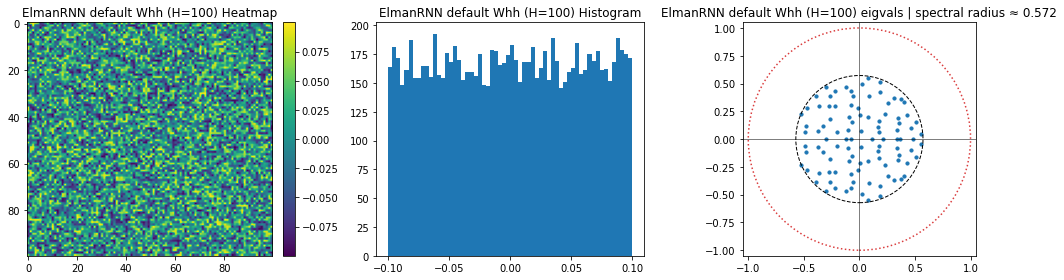

In [4]:
model = ElmanRNN_pytorch_module_v2(100, 100, 100)
W_hh = model.rnn.weight_hh_l0.detach().cpu().numpy()
bhw.plot_weight_all(W_hh, title=f"ElmanRNN default Whh (H={100})")

## Utility

In [5]:
# =========================
# Example usage
# =========================

save_dir = "../data/Ns100_SeqN100/hidden-weight-inits"
n = 100
target_gain = 0.90  # primary control for dynamics
target_var = theo_var  # optional: report/compare but gain wins last
inits = []

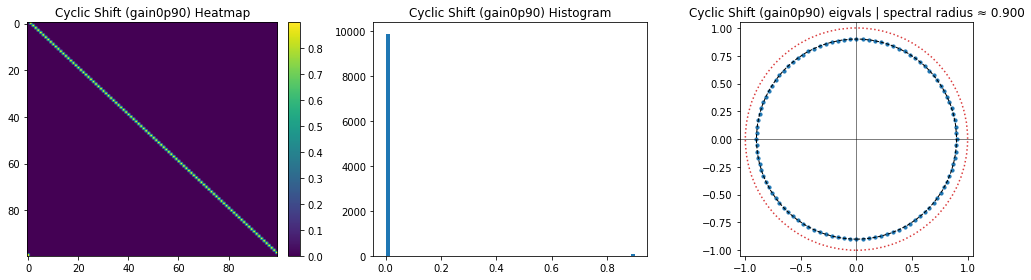

In [6]:
# --- Shift (cyclic) ---
W = bhw.build_shift(
    n, off=1.0, cyclic=True, target_var=None, target_gain=None, verbose=True
)
# optional biological tweaks BEFORE final gain scaling:
# W = impose_dale_law_np(W, frac_exc=0.8, balanced_rows=True, seed=0)
# W = apply_sparsity_np(W, p=0.3, seed=0)
# W = add_gaussian_noise_np(W, noise_std=1e-3, seed=0)
# now gain match
W, _ = bhw.scale_to_gain_np(W, target_gain)
inits.append(("cyclic_shift", W))
bhw.plot_weight_all(W, title=f"Cyclic Shift ({bhw.gain_tag(target_gain)})")
name = f"hidden_cyclic_shift_n{n}_{bhw.gain_tag(target_gain)}"
# bhw.save_matrix(
#    W, save_dir, name, meta={"type": "cyclic_shift", "n": n, "target_gain": target_gain}
# )

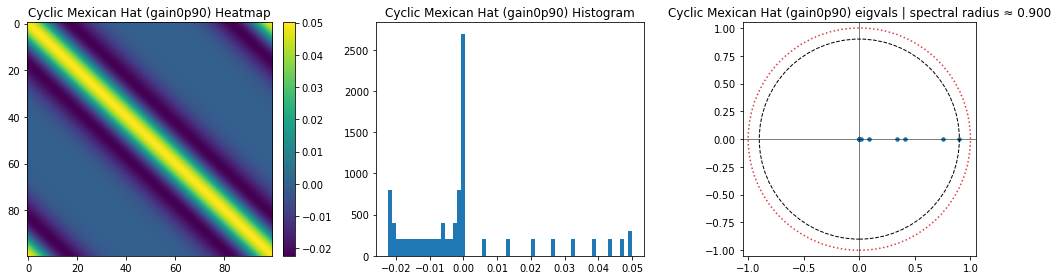

In [7]:
# --- Mexican hat (cyclic) ---
W = bhw.build_mexican_hat(
    n=n, sigma=None, cyclic=True, target_var=None, target_gain=None, verbose=True
)
# (optional) W = impose_dale_law_np(W, frac_exc=0.8, balanced_rows=True, seed=0)
# (optional) W = apply_sparsity_np(W, p=0.5, seed=1)
# (optional) W = add_gaussian_noise_np(W, noise_std=5e-4, seed=0)
W, _ = bhw.scale_to_gain_np(W, target_gain)
inits.append(("mexican_hat_cyc", W))
bhw.plot_weight_all(W, title=f"Cyclic Mexican Hat ({bhw.gain_tag(target_gain)})")
name = f"hidden_cmh_n{n}_{bhw.gain_tag(target_gain)}"
# bhw.save_matrix(
#    W,
#    save_dir,
#    name,
#    meta={"type": "cyclic_mexican_hat", "n": n, "target_gain": target_gain},
# )

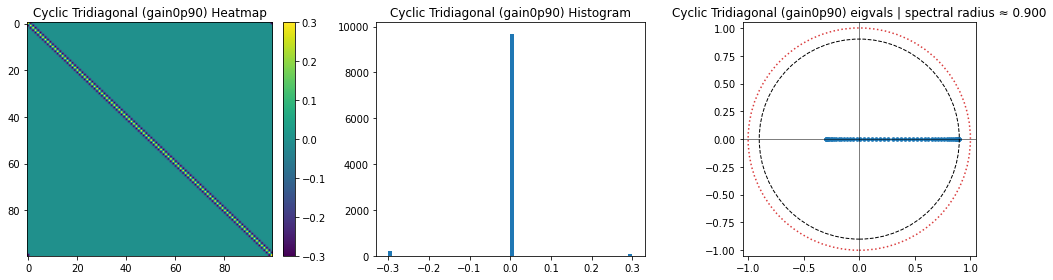

In [8]:
# --- Tridiagonal (cyclic) ---
W = bhw.build_tridiag(
    n, off=-1.0, cyclic=True, target_var=None, target_gain=None, verbose=True
)
# (optional tweaks) ...
W, _ = bhw.scale_to_gain_np(W, target_gain)
inits.append(("tridiag_cyc", W))
bhw.plot_weight_all(W, title=f"Cyclic Tridiagonal ({bhw.gain_tag(target_gain)})")
name = f"hidden_ctridiag_n{n}_{bhw.gain_tag(target_gain)}"
# bhw.save_matrix(
#    W,
#    save_dir,
#    name,
#    meta={"type": "cyclic_tridiagonal", "n": n, "target_gain": target_gain},
# )

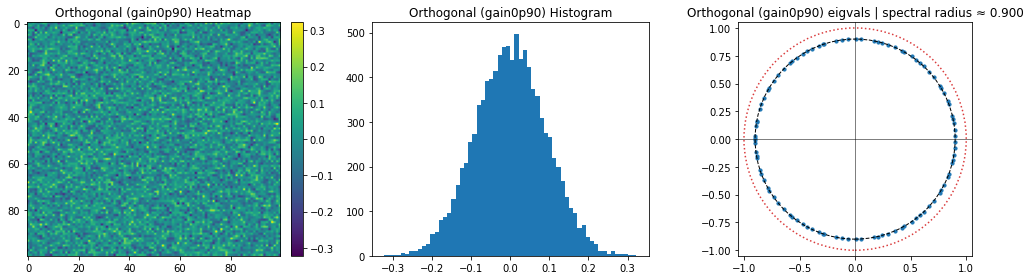

In [9]:
# --- Orthogonal ---
W = bhw.build_orthogonal(
    n, scale=1.0, seed=0, target_var=None, target_gain=None, verbose=True
)
# (optional tweaks) ...
W, _ = bhw.scale_to_gain_np(W, target_gain)
inits.append(("orthogonal", W))
bhw.plot_weight_all(W, title=f"Orthogonal ({bhw.gain_tag(target_gain)})")
name = f"hidden_orthog_n{n}_{bhw.gain_tag(target_gain)}"
# bhw.save_matrix(
#    W, save_dir, name, meta={"type": "orthogonal", "n": n, "target_gain": #target_gain}
# )

In [10]:
# summarize and check
bhw.summarize_many(inits, target_gain)
_ = bhw.check_gain_alignment(inits, target_gain, rtol=1e-3)

=== Weight init summary ===
[        cyclic_shift] var=0.008019  σ_max=0.9000  ρ=0.9000  asym=1.4142  mean=9.000e-03  |  gain_err=2.384e-08 (rel 0.00%)
[     mexican_hat_cyc] var=0.000333346  σ_max=0.9000  ρ=0.9000  asym=0.0000  mean=1.901e-07  |  gain_err=3.576e-08 (rel 0.00%)
[         tridiag_cyc] var=0.002691  σ_max=0.9000  ρ=0.9000  asym=0.0000  mean=-3.000e-03  |  gain_err=3.576e-08 (rel 0.00%)
[          orthogonal] var=0.00809903  σ_max=0.9000  ρ=0.9000  asym=1.3997  mean=9.830e-04  |  gain_err=3.576e-08 (rel 0.00%)
=== Gain alignment check (target_gain=0.9) ===
[        cyclic_shift] σ_max=0.900000  rel_err=0.000%  -> OK
[     mexican_hat_cyc] σ_max=0.900000  rel_err=0.000%  -> OK
[         tridiag_cyc] σ_max=0.900000  rel_err=0.000%  -> OK
[          orthogonal] σ_max=0.900000  rel_err=0.000%  -> OK
